# Simulations & Monte Carlo Methods in Python for Option Pricing

# 1. Random Numbers

Random numbers in computer science are pseudo-random numbers, i.e. generated by an algorithm but, without knowing the algorithm and the starting value for that algorithm, we have no way of knowing what led up to that number's generation.

**Quasi-Random Numbers** discard the attempt to appear random and instead attempt to fill a space in an optimally regular way (can help Monte Carlo simulation converge to the correct answer faster).

### Methods of Generating Psuedo-Random Numbers

### a. Linear Congruential Generators

These are generally the simplest form of random number generators and are very limited in the distributions for which they can generate numbers. 

However, **they help us to generate numbers from the uniform distribution**, which can be used, alongside more sophisticated techniques, to generate random numbers from more complex distributions.

They generate random numbers in a sequence. the $n + 1^{th}$ number is defined recursively by the $n^{th}$ number as follows:

$$X_{n+1} = (aX_n + c) \mod m$$

Where, 
$a$, $c$ and $m$ are integers with a **seed value** of $X_0$ that needs to be defined at the beginning in order to start generating the sequence.

In [1]:
def lin_con_gen(n, a, c, m, x_0):
    """
    Generates n numbers from the linear congruential generator with parameters
    a,c,m and seed x_0
    """
    random_list = [None]*n
    random_list[0] = (a*x_0+c)%m
    for i in range(1,n):
        random_list[i] = (a*random_list[i-1]+c)%m
    return random_list

In [21]:
lin_con_gen(10, 100, 400, 0.3, 0.2)

[1.554312234475219e-14,
 0.10000000000154957,
 0.20000000015497033,
 1.549706629688785e-08,
 0.10000154970662495,
 0.20015497066250798,
 0.015497066250831804,
 0.14970662508317567,
 0.07066250831757487,
 0.2662508317575012]

The numbers generated are part of the set {0, 1, 2, ... , 𝑚 − 1}. In order to approximate the uniform distribution, the generated numbers can all be divided by 𝑚 (this will create numbers that lie between 0 and 1). These numbers will be discrete, unlike the uniform distribution. The larger 𝑚 is, the greater the number of values our algorithm can produce. With these approximately uniform numbers, we can now generate from other distributions.

### b. Generating Uniform Random Numbers with SciPy

In [19]:
import numpy as np
from scipy.stats import uniform

unif_array = uniform.rvs(size=10)
unif_array

array([0.81046728, 0.85673379, 0.28657735, 0.66266419, 0.6732497 ,
       0.07286009, 0.47169736, 0.9778669 , 0.9135519 , 0.15990825])

### c. The Inverse Transform Method

Suppose we have a uniformly distributed random variable, $U \sim U(0,1)$. For some continuous CDF, F, if we let:

$$X := F^{-1}[U]$$

Then X is distributed with the same CDF as F

This is very useful for sampling from more complex distribution with the biggest drawback being the need to find the inverse cumulative distribution function of a random variable (may not be possible).

#### Example: Exponential Distribution

Suppose we let $X \sim e^{\lambda}$. Then:

$$ f(x) = \lambda e^{-\lambda x} $$
$$ F(x) = 1 - e^{-\lambda x} $$

Where, x is defined on $[0, \infty]$. By re-arranging the equation we get:

$$ u = 1 - e^{-\lambda x} $$
$$ x = -\frac{1}{\lambda}ln[1-u] $$

This transformation is useful as we can now generate values from an exponential distribution, with mean $\frac{1}{\lambda} simply by sampling from a uniform distribution.

In [53]:
# generating uniform random variables
unif_array = uniform.rvs(size=10000)

# generating exponential random variables
lambda_value = 1
expo_array = -np.log(1-unif_array)/lambda_value

In [54]:
expo_array

array([0.33110567, 2.06055491, 0.532544  , ..., 3.01300764, 0.96653865,
       0.5937264 ])

### d. The Rejection Method

Is an algorithm that allows us to sample from a wider range of distributions than the previous method. Three things are needed:

- A sample from the Uniform Distribution


- A sample from another distribution


- Some constant which is always greater than the ratio of the distribution we can sample from and the one we cannot

#### In Practice

Suppose we are trying to generate a sample from the random variable, X, which has distribution, $f$.

For a random variable $Y$, with distribution, $g$, and a constant, c, such that $c \geq \frac{f(y)}{g(y)}$

#### Algorithm

1. Generate a value, $u$, from a U(0,1) distribution


2. Generate a value, $y$, from some distribution Y


3. Check if $u < \frac{f(y)}{cg(y)}$ then set X = y, else reject this value for $y$ and start again.

**N.B.** we are substituting the value 𝑦 into the functions 𝑔 and 𝑓, and then checking if the relevant criteria is met.

#### In Summary

The rejection method essentially works by taking two overlapping distributions. We then sample from the one, and check whether the value sampled comes from the area that is overlapping or the area that is not overlapping. The number gets rejected if the sample comes from the non- overlapping area. (It is therefore not reflective of the distribution we are trying to sample from.)

The value that we use for 𝑐 is also particularly important as it can be shown that the probability that we accept a sample is equal to $\frac{1}{c}$. This means that we want to choose a random variable, 𝑌, that allows us to choose the smallest possible value of 𝑐, as it will allow us to minimize how many times we would need to run this algorithm to generate a fixed sample from 𝑋.

#### Applying it to the Exponential Distribution

Let $Y \sim exp(\lambda)$, and $X \sim N(0,1)$

The exponential distribution is always positive so we are simulating the absolute value of the normal distribution.

$$g(y) = \lambda e^{\lambda x}$$
$$f(x) = \frac{2}{\sqrt{2 \pi}}e^{\frac{-x^2}{2}}$$

We need to update our algorithm slightly to allow for negative values. Note that the standard normal distribution has an equal probability of being positive and negative. So, if we accept that value of 𝑌, then we can apply the following algorithm:

1. Generate a value, $w$, from a U(0,1) distribution


2. if $w < 0.5$ set X=Y


3. Else set X = -Y

In [39]:
import math as m

norm_size = 10000
norm_array = [None]*norm_size
lambda_val = 1
count = 0
c = m.sqrt(2*m.exp(1)/m.pi)

while count < norm_size:
    # generating uniform random variables
    unif_val_1 = uniform.rvs(size=1)
    # generating exponential random variables
    unif_val_2 = uniform.rvs(size=1)
    expo_val = -np.log(unif_val_2)/lambda_val
    norm_val = 2*m.exp(-expo_val**2/2)/m.sqrt(2*m.pi)
    
    if unif_val_1 < norm_val/(c*expo_val):
        unif_val_3 = uniform.rvs(size=1)
        if unif_val_3 < 0.5:
            norm_array[count] = expo_val
        else:
            norm_array[count] = -expo_val
        count += 1
    else:
        continue

#### Using Scipy to Simplify the code:

In [56]:
from scipy.stats import norm

# generating standard normal variables
norm_array = norm.rvs(size=10)
norm_array

array([-0.41901174, -1.39995866, -1.44863212, -0.90447976,  1.0790935 ,
       -0.55840348, -1.05639277, -1.13566126,  0.15396793, -0.03011434])

## Generating From the Multivariate Normal Distribution

Some financial products are written on more than one asset. For example, a basket option is written on several different underlying shares. Within the Black-Scholes framework, each of these assets is distributed log-normally. This means that, in order to simulate these types of options, we need to be able to generate from the multivariate normal distribution (MVN), which is just the multidimensional equivalent of the normal distribution. 

Correlations are assumed to be non-zero.

### Assumptions

Suppose we want to sample from $X \sim MVN(0, \Sigma)$.

Since $\Sigma$ is a positive semi-definite matrix (as it is a covariance matrix), there exists some matrix $L$ such that:

$$ \Sigma = LL' $$

Where $L'$ is the transpose of L.

We can now rewrite it as:

$$ X = LY, Y \sim MVN(0, I)$$

With I being the identity matrix.

In other words, if you can find 𝐿, all you need to do to sample from a correlated multivariate normal distribution is a sample from an uncorrelated normal distribution. 

We can generate X though Y if we can find L since variance of Y is the identity matrix:

$$LY \sim MVN(0,LIL') \sim MVN(0, \Sigma)$$

With $LL' = \Sigma$

### Cholesky Decomposition

Is a possible solution to the equation that generates an L that is lower triangular.

Suppose you wanted to generate two random numbers from the normal distribution, both with mean 0 and variance 1, but with a correlation of 0.5. This can be done by first generating two uncorrelated standard normal random variables, followed by finding the Cholesky decomposition of the desired correlation matrix, and finally multiplying the vector of generated numbers by the decomposition.

In [42]:
# Cholesky Decomposition
Sigma = np.array([[1,0.5],[0.5,1]])
L = np.linalg.cholesky(Sigma)

In [43]:
uncorr_norms = norm.rvs(size=2)
corr_norms = np.matmul(L, uncorr_norms)

In [57]:
corr_norms

array([1.38815118, 0.10279167])

The variable corr_norms contains the two correlated random normals. Correlated numbers like these can be used to simulate correlated stock prices in a Black-Scholes world by noting that, within this framework, stock prices are log-normally distributed.

# 2. Monte Carlo Simulation

Monte Carlo estimation is a technique which relies on random sampling. One of its uses is in estimating the value of an integral. This relies on the Law of Large Numbers and the Central Limit Theorem in order to justify its estimate.

Suppose we want to evaluate the integral:

$$I_A(f) = \int_A f(x) dx$$

Here we are integrating the function $f(x)$ over the set A. This set A could be any closed or open or discrete set.

Let us assume that: $f(x) = g(x)h(x)$

$$\int_A f(x) dx = \int_A g(x)h(x) dx = E[g(X);A]$$

Where X is a RV with pdf given by $h(x)$ and $E[g(X);A]$ represents the expected value of $g(x)$ over the set A.

This means that any integral can be re-expressed as an expectation of a function of a random variable over a given set.


## Law of Large Numbers

Suppose we have i.i.d RVs $X_1, X_2, ..., $ with:

$$ E[g(X_i)] = \mu $$
then
$$ \lim_{n \to \infty} \frac{1}{n} \Sigma_{i=1}^n g(X_i) = \mu $$

This theorem states that, as the number of random variables we simulate increases towards
infinity, the sample mean converges to the expected value of the function of the random variables.

We can get an estimate for an expectation by simulating a large number of $X_i$, each with a PDF of $h(x)$, and calculating the sample mean of $g(X_i)$. The set A needs to be the sample space of the RV (since the simulation is dove over the sample space).

### Example: Sin(X)

This has a closed-form solution:

$$ \int_0^{\pi} sin x dx = -cos \pi + cos 0 = 2 $$

Using the Monte Carlo Estimation we get:

$$ \int_0^{\pi} sin(x) dx = \pi \int_0^{\pi} \frac{1}{\pi} sin(x) dx = \pi E[sin(X)]$$

Where $X \sim U(0, \pi)$.

Here, the PDF is give by $\frac{1}{\pi}$ which is the $h(x)$ we used above and $g(x)$ is given by sin(X).

The set A being integrated over $[0, \pi]$ which is the sample space for a $U(0, \pi)$ variable, and so we omit the A in the expectation.

In practice, we would simulate a large number of variables from a $U(0, \pi)$ distribution, calculate sine of each of these, work out the sample mean and finally multiply this by $\pi$ (this is why this term is outside the expectation).

### Error Analysis and Central Limit Theorem

Because the Law of Large Numbers involves a limit as 𝑛𝑛 tends to infinity, the simulated variables and the sample mean will not be exactly equal to the true underlying mean, since we are only simulating finitely many variables. As a result, discrepancies will arise between the Monte Carlo estimate and the true underlying values. We would like to quantify this error, which is where the Central Limit Theorem comes in.

#### Central Limit Theorem

Suppose we have i.i.d RVs $X_1, X_2, ..., $ with $E[X_i] = \mu$ and $Var[X_i] = \sigma^2$ then:

$$ \lim_{n \to \infty} \frac{1}{\sqrt{n}}\Sigma_{i=1}^n (X_i - \mu) \sim N(0, \sigma^2)$$

This means, as our sample size grows larger, the variable $\frac{1}{n} \Sigma_{i=1}^n X_i$ converges in distribution to $N(\mu, {\frac{\sigma^2}{n}})$ giving us an idea of the degree of error we can expect in our Monte Carlo Simulation.

#### Creating Confidence Intervals for the True Underlying Mean given the Observed Mean

for an $N \sim (\hat{\mu}, \hat{\sigma}^2)$ RV:

$$ \Phi(\hat{\mu} + 3\hat{\sigma}) - \Phi(\hat{\mu} - 3\hat{\sigma}) \approx 0.997$$

Where $\Phi$ is the normal CDF

#### CLT Applied to Monte Carlo Estimates

Since the CLT tells us that our sample mean tends in distributino to a normal distribution with mean $\mu$ and variance $\frac{\sigma^2}{n}$, then the interval:

$$[\bar{X}-3 \frac{\sigma}{\sqrt{n}}, \bar{X}+3 \frac{\sigma}{\sqrt{n}}]$$

Will contain the true mean, $\mu$ with probability 0.997.

Where, 
$\bar{X} = \frac{1}{n}\Sigma_{i=1}^n X_i$

This is the 99.7% confidence interval for our true mean, given a sample mean. As you can see, the larger 𝑛 is, the narrower the confidence interval will be. This means that, as we simulate more 𝑋𝑖, the closer our sample mean will be to the true mean.

#### Using Sample Mean and Variance

If we don't know the true mean and variance, we can estimate the true variance by using the unbiased sample variance:

$$\hat{\sigma}^2 = \frac{1}{n-1}\Sigma_{i=1}^n (X_i - \bar{X})^2$$

and we can construct our 99.7% CI as follows:

$$[\bar{X}-3 \frac{\hat{\sigma}}{\sqrt{n}}, \bar{X}+3 \frac{\hat{\sigma}}{\sqrt{n}}]$$

# 3. Applying Monte Carlo Estimation in Python

Let us represent our Monte Carlo estimates as a function of sample size as this is gives a good illustration of how the Monte Carlo estimate converges to the true value.

In [44]:
import numpy as np
np.random.seed(0)

## Monte Carlo for sin(x)

We will go through the estimation of the value of the following integral:

$$ \int_0^{\pi} sin(x) dx $$

This can be re-written as:

$$ \pi \int_0^{\pi} \frac{1}{\pi} sin(x) dx = \pi E[sin(x)] $$

In [45]:
# Simulating the value of the sin integral

# create empty vectors that we can use to store the value 
# of the Monte Carlo estimates and standard deviations, with 50 different sample sizes,
# ranging from 1000 to 50000
# This will be useful for plotting these values later

msin_estimates = [None]*50
msin_std = [None]*50

for i in range(1, 51):
    # generate uniform random variables creating 1000x1 vector of numbers from U(0,1)
    # We then times this by pi so that our numbers are sampled from U(0, pi)
    unif_array = uniform.rvs(size = i*1000)*np.pi
    
    # create temp value that holds the sin function valuations
    sin_val = np.sin(unif_array)*np.pi
    
    # Calculate the Monte Carlo estimate for the given sample size
    # The np.mean function returns the average value of the sin_val vector 
    # i.e. the Monte Carlo estimate.
    msin_estimates[i-1] = np.mean(sin_val)
    
    # calculate the standard deviation of the sample 
    # and scale it by the square-root of the sample size.
    # This calculates the SD of the simulated MC estimator
    msin_std[i-1] = np.std(sin_val)/np.sqrt(i*1000)

#### Plotting the Estimates Against the True Value

and include error bounds for our estimates

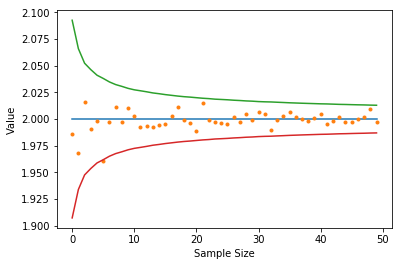

In [51]:
import matplotlib.pyplot as plt

# plot the analytical solution of the integral as a line
plt.plot([2]*50)
# plot the Monte Carlo Estimates for the integral
plt.plot(msin_estimates, ".")
# plot 3 SD error bounds around our analytical solution
plt.plot(2+np.array(msin_std)*3)
plt.plot(2-np.array(msin_std)*3)
plt.xlabel("Sample Size")
plt.ylabel("Value")
plt.show()

### Monte Carlo for: 

$e^{-x^2}$

$$ \int_{-\infty}^{\infty} e^{-x^2} dx $$

The closed form solution is: $\sqrt{\pi}$

With:

$$f(x) = \frac{2}{\sqrt{2 \pi}}e^{\frac{-x^2}{2}}$$

and,

$$[\bar{X}-3 \frac{\hat{\sigma}}{\sqrt{n}}, \bar{X}+3 \frac{\hat{\sigma}}{\sqrt{n}}]$$

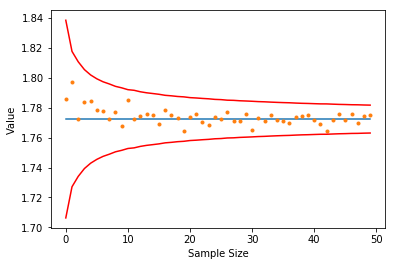

In [50]:
np.random.seed(0)

mexp_est = [None]*50
mexp_std = [None]*50

for i in range(1, 51):
    norm_array = norm.rvs(size=i*1000)
    exp_value = np.exp(-norm_array**2/2)*np.sqrt(2*np.pi)
    mexp_est[i-1] = np.mean(exp_value)
    mexp_std[i-1] = np.std(exp_value)/np.sqrt(i*1000)
    
plt.plot([np.sqrt(np.pi)]*50)
plt.plot(mexp_est, ".")
plt.plot(np.sqrt(np.pi)+np.array(mexp_std)*3, "r")
plt.plot(np.sqrt(np.pi)-np.array(mexp_std)*3, "r")
plt.xlabel("Sample Size")
plt.ylabel("Value")
plt.show()

# 4. Pricing Options with Monte Carlo

We will initially restrict ourselves to pricing vanilla European Options within a Black-Scholes framework - as these options have a closed-form solution to which we can compare our Monte Carlo estimates.

## The Black-Scholes Market Model

Provides a SDE which models the changes in a given stock's price over time. This relies on a set of unrealistic assumptions as follows:

#### Assumptions:

- There is a constant, continuously compounded, risk-free rate of 𝑟



- There is no default risk, no transaction costs, no spreads, no tax, and no dividends



- Markets are perfectly liquid with unlimited short-selling permitted



- No arbitrage is possible

### Black-Scholes Model Derivation

Given the filtered probability space (Ω,F,𝐹, 𝒫), a stock price's dynamics are given by:

$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$
$$S_0 = S $$

where 𝑆𝑡 is the stock’s price at time 𝑑, μ and σ are known constants that represent the mean return
and volatility of the stock respectively, and 𝑊𝑡 is a standard Brownian motion.

#### Risk-Neutral Measure Dynamics

Based on our no-arbitrage assumption, the risk neutral measure is the measure under which the discounted stock prices are Martingales:

$$ E^Q[e^{-rT}S_T|F_t] = e^{-rt}S_t $$

Where Q is the risk-neutral measure and $F_t$ is the filtration at time t, and r is the risk-free interest rate (that investors are able to earn from their bank account, which we will assume that the bank will always accept any investment and there is no risk of bank default).

#### Solving the SDE for 

$S_t$

We use Ito's Lemma on a transformation of $S_t$ as follows:

$$d(lnS_t) = \frac{1}{S_t} dS_t - \frac{1}{2}\frac{1}{S^2_t}{dS_t}^2$$
$$ = \frac{1}{S_t}(rS_tdt + \sigma S_t dW_t^Q) - \frac{1}{2}\frac{1}{S_t^2}(\sigma S_t)^2dt $$
$$ = rdt + \sigma dW_t^Q - \frac{\sigma^2}{2}dt $$
$$ = (r - \frac{\sigma^2}{2})dt + \sigma dW_t^Q $$

We can integrate this expression to give:

$$ ln(S_T) - ln(S_0) = (r - \frac{\sigma^2}{2})T + \sigma dW_t^Q $$
$$ \Rightarrow S_T = S_0 e ^{((r - \frac{\sigma^2}{2})T + \sigma W_T^Q)}$$

We can re-map the Brownian Motion, $W_T^Q$ by simulating a standard normal variable, X, and then multiplying it by the square root of T in order to use this formula:

$$ W_T^Q \sim N(0, T) $$

$$ \sqrt{T}Z \sim N(0,T) $$

Where, $Z \sim N(0,1)$

Therefore, we can re-write the formula for $S_T$ as follows:

$$ S_T = S_0 e^{((r - \frac{\sigma^2}{2})T + \sigma \sqrt{T} Z)} $$

with Z being a standard normal random variable.

## Option Pricing in Python

Let us price a **Vanilla European Call Option**. We require the following parameters:



- Continuously compounded, risk-free interest rate, $r$



- Stock volatility, $\sigma$



- Initial stock price, $S_0$



- Option strike price, $K$



- Option maturity, $T$


### Payoff of a Call Option

$$ (S_T - K)^+ = max(S_T - K, 0) $$

We exercise the right to buy the stock for the price K when the value of the stock is greater than K, netting us a profit of $S_T - K$. If the stock is worth less than K, we do not exercise the option and hence it has no value.

By the risk-neutral pricing argument, the pric of the call option is given by:

$$ E^Q[e^{-rT}(S_T - K)^+] $$

Since this is an expectation, we are able to use the Monte Carlo methods to price this option.

This means, that we are going to simulate the random variable corresponding to the terminal stock price, $S_T$ and the function we are going to take of it is:

$$ f(S_T) = e^{-rT}(S_T - K)^+ $$

In [58]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import math as m
import random as r

#### Information

- risk-free rate, 𝑟, is 10%;



- the initial stock price, 𝑆 is 100;



- our stock volatility, σ, is 30%;



- the strike price, K, is 110;



- the terminal/maturity time, T, is 1;



- current time is 0

In [59]:
# Share specific info
risk_free = 0.1
S_0 = 100
sigma = 0.3

# Option specific info
strike = 110
T = 1
current_time = 0

In [64]:
def terminal_shareprice(S_0, risk_free_rate, sigma, Z, T):
    """
    Generates the terminal share price given some random normal values, z
    """
    # It returns an array of terminal stock prices.
    return S_0*np.exp((risk_free_rate-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

def discounted_call_payoff(S_T, K, risk_free_rate, T):
    """
    Function for evaluating the discounted payoff of a call option
    in the Monte Carlo Estimation
    """
    # It returns an array which has the value of the call for each terminal stock price.
    return np.exp(-risk_free_rate*T)*np.maximum(S_T - K, 0)

In [66]:
# Generate Monte Carlo estimates of Vanilla European Call Options
np.random.seed(0)

# Empty arrays which can be used to store estimate values for different
# sample size
mcall_est = [None]*50
mcall_std = [None]*50

# Generating Monte Carlo estimates as a function of sample size
# The for loop implements Monte Carlo for a number of different sample sizes.
for i in range(1, 51):
    # creates an array of standard normal random variables, which are 
    norm_array = norm.rvs(size = 1000*i)
    # used to simulate terminal stock prices
    term_val = terminal_shareprice(S_0, risk_free, sigma, norm_array, T-current_time)
    # These terminal stock prices are passed into the function which values 
    # a call on the stock
    mcall_val = discounted_call_payoff(term_val, strike, risk_free, T-current_time)
    # store the mean and SD of these call values
    mcall_est[i-1] = np.mean(mcall_val)
    mcall_std[i-1] = np.std(mcall_val)/np.sqrt(i*1000)

### Analytical Solution

In [67]:
# Code for the analytical solution for Vanilla European Call Options
d_1 = (np.log(S_0/strike) + (risk_free + sigma**2/2)*(T - current_time))/(sigma*m.sqrt(T-current_time))
d_2 = d_1 - sigma*m.sqrt(T-current_time)

analytic_callprice = S_0*norm.cdf(d_1) - strike*m.exp(-risk_free*(T-current_time))*norm.cdf(d_2)

With the closed form solution given by:

$$ S_0 \Phi(-d_1) - \Phi(-d_2)Ke^{-rT} $$

where, 

$$ d_1 = \frac{ln(\frac{S_0}{K}) + (r+\frac{\sigma^2}{2})T}{\sigma \sqrt{T}} $$
$$ d_2 = d_1 - \sigma \sqrt{T} $$

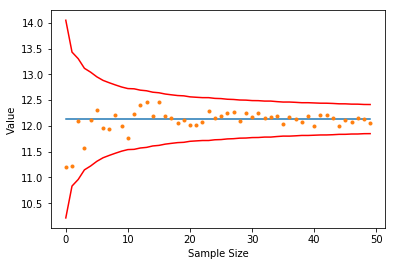

In [68]:
# plotting the graph
plt.plot([analytic_callprice]*50)
plt.plot(mcall_est, ".")
plt.plot(analytic_callprice+3*np.array(mcall_std), "r")
plt.plot(analytic_callprice-3*np.array(mcall_std), "r")
plt.xlabel("Sample Size")
plt.ylabel("Value")
plt.show()